# Diagnostics & Submissions

In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numerapi import NumerAPI
from utils.api_keys import PUBLIC_ID, SECRET_KEY
from utils.api_keys import (
    FOXHOUND_MODEL_ID, DEADCELL_MODEL_ID, COBRA_MODEL_ID,
    BEAUTYBEAST_MODEL_ID, SKULLS_MODEL_ID, DESPERADO_MODEL_ID
)

In [2]:
# instantiate api & check for round
napi = NumerAPI(public_id=PUBLIC_ID, secret_key=SECRET_KEY)
current_round = napi.get_current_round()
print(f"Current round #: {current_round}")

Current round #: 315


In [3]:
# era corr function
def compute_corr_by_era(val_df, model_list, corr_method):
    df_list = []
    for m in model_list:
        r = val_df.groupby("era")[["target", m]].corr(method=corr_method).iloc[0::2, -1]
        df = pd.DataFrame(r)
        df_list.append(r)
    df_all = pd.concat(df_list, axis=1).dropna().reset_index()
    return df_all.drop("level_1", axis=1).set_index("era")

---
# Load validation datesets

In [4]:
# read current round's validation preds
validation_data = pd.read_parquet('data/validation.parquet', columns=["era", "target"]).reset_index()
foxhound_val = pd.read_csv(f"predictions/dh_foxhound_v0_val_preds.csv")
deadcell_val = pd.read_csv(f"predictions/dh_deadcell_v0_val_preds.csv")
cobra_val = pd.read_csv(f"predictions/dh_cobra_v0_val_preds.csv")
beautybeast_val = pd.read_csv(f"predictions/dh_beautybeast_v0_val_preds.csv")
desperado_val = pd.read_csv(f"predictions/dh_desperado_v0_val_preds.csv")

print(f"""
    Numerai validation     : {len(validation_data)}
    Foxhound predictions   : {len(foxhound_val)}
    Deadcell pedictions    : {len(deadcell_val)}
    Cobra pedictions       : {len(cobra_val)}
    BeautyBeast pedictions : {len(cobra_val)}
    Desperado pedictions   : {len(desperado_val)}
    """)


    Numerai validation     : 2203644
    Foxhound predictions   : 2203644
    Deadcell pedictions    : 2203644
    Cobra pedictions       : 2203644
    BeautyBeast pedictions : 2203644
    Desperado pedictions   : 2203644
    


In [5]:
# join as master validation set
val = validation_data.merge(
    right=foxhound_val, how='inner', on="id").merge(
    right=deadcell_val, how='inner', on="id", suffixes=('', '2')).merge(
    right=cobra_val, how='inner', on="id", suffixes=('', '3')).merge(
    right=beautybeast_val, how='inner', on="id", suffixes=('', '4')).merge(
    right=desperado_val, how='inner', on="id", suffixes=('', '5'))

val.columns = ["id", "era", "target", "foxhound", "deadcell", "cobra", "beautybeast", "desperado"]
val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2203644 entries, 0 to 2203643
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           object 
 1   era          object 
 2   target       float32
 3   foxhound     float64
 4   deadcell     float64
 5   cobra        float64
 6   beautybeast  float64
 7   desperado    float64
dtypes: float32(1), float64(5), object(2)
memory usage: 142.9+ MB


In [6]:
# view data
val.head()

,id,era,target,foxhound,deadcell,cobra,beautybeast,desperado
0,n000101811a8a843,0575,0.50,0.129369,0.083149,0.009770,0.113878,0.084041
1,n001e1318d5072ac,0575,0.00,0.439908,0.511116,0.763217,0.829601,0.635960
2,n002a9c5ab785cbb,0575,0.50,0.834553,0.442237,0.684775,0.823740,0.696326
3,n002ccf6d0e8c5ad,0575,0.25,0.929264,0.899298,0.881232,0.997238,0.926758
4,n0051ab821295c29,0575,0.50,0.169530,0.265021,0.035853,0.142973,0.153345


---
# Get correlation by era

In [7]:
# models
model_names = ["foxhound", "deadcell", "cobra", "beautybeast", "desperado"]

In [8]:
# get corrs
pearson_corr = compute_corr_by_era(val_df=val, model_list=model_names, corr_method="pearson")
spearman_corr = compute_corr_by_era(val_df=val, model_list=model_names, corr_method="spearman")

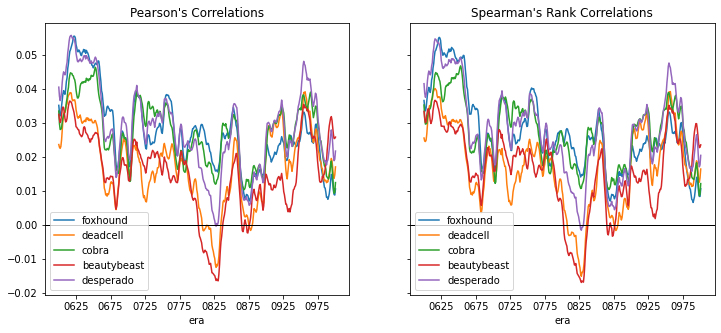

In [9]:
# correlation plots
ROLLING_FACTOR = 26

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 5))
pearson_corr.rolling(ROLLING_FACTOR).mean().plot(ax=axes[0]);
spearman_corr.rolling(ROLLING_FACTOR).mean().plot(ax=axes[1]);
axes[0].set_title("Pearson's Correlations")
axes[1].set_title("Spearman's Rank Correlations")
axes[0].axhline(0, color ='black', linewidth=1)
axes[1].axhline(0, color ='black', linewidth=1)
plt.show()

In [10]:
# compute sharpe ratio
sharpe_df = pd.concat([
    (pearson_corr.mean() / pearson_corr.std()),
    (spearman_corr.mean() / spearman_corr.std())], axis=1)

sharpe_df.columns = ["sharpe_pearson", "sharpe_spearman"]
round(sharpe_df, 2)

,sharpe_pearson,sharpe_spearman
foxhound,1.01,0.99
deadcell,0.62,0.59
cobra,0.99,0.97
beautybeast,0.61,0.60
desperado,0.92,0.88


In [45]:
# compute pct rank of validation era each model
pearson_rank_per_era = pearson_corr.rank(axis=1, ascending=False)
spearman_rank_per_era = spearman_corr.rank(axis=1, ascending=False)

rank_as_top = pd.concat([
    pd.DataFrame({
        "foxhound": [np.sum([r for r in pearson_rank_per_era["foxhound"] if r == 1])],
        "deadcell": [np.sum([r for r in pearson_rank_per_era["deadcell"] if r == 1])],
        "cobra": [np.sum([r for r in pearson_rank_per_era["cobra"] if r == 1])],
        "beautybeast": [np.sum([r for r in pearson_rank_per_era["beautybeast"] if r == 1])],
        "desperado": [np.sum([r for r in pearson_rank_per_era["desperado"] if r == 1])],
    }) / len(pearson_rank_per_era.index),
    pd.DataFrame({
        "foxhound": [np.sum([r for r in spearman_rank_per_era["foxhound"] if r == 1])],
        "deadcell": [np.sum([r for r in spearman_rank_per_era["deadcell"] if r == 1])],
        "cobra": [np.sum([r for r in spearman_rank_per_era["cobra"] if r == 1])],
        "beautybeast": [np.sum([r for r in spearman_rank_per_era["beautybeast"] if r == 1])],
        "desperado": [np.sum([r for r in spearman_rank_per_era["desperado"] if r == 1])],
    }) / len(spearman_rank_per_era.index),
])

rank_as_top.index = ["pearson_corr", "spearman_corr"]
round(rank_as_top, 2)


,foxhound,deadcell,cobra,beautybeast,desperado
pearson_corr,0.30,0.12,0.25,0.14,0.20
spearman_corr,0.32,0.11,0.26,0.15,0.16


---
# Submit predictions

In [46]:
# file and id lists
model_files = ["dh_foxhound_v0", "dh_deadcell_v0", "dh_cobra_v0", "dh_beautybeast_v0", "dh_desperado_v0"]
model_ids = [FOXHOUND_MODEL_ID, DEADCELL_MODEL_ID, COBRA_MODEL_ID, BEAUTYBEAST_MODEL_ID, DESPERADO_MODEL_ID]


In [47]:
# # submit validation predictions for diagnosis
# for f, i in zip(model_files, model_ids):
#     print(f"Submitting validation predictions for: {f}...")
#     napi.upload_diagnostics(
#         file_path=f"predictions/{f}_val_preds.csv",
#         model_id=i
#     )

In [48]:
# submit live predictions for current round
for f, i in zip(model_files, model_ids):
    print(f"Submitting live predictions for {f}...")
    napi.upload_predictions(
        file_path=f"predictions/{f}_live_preds_{current_round}.csv",
        model_id=i
    )

2022-05-07 15:10:44,833 INFO numerapi.base_api: uploading predictions...


Submitting live predictions for dh_foxhound_v0...


2022-05-07 15:10:54,546 INFO numerapi.base_api: uploading predictions...


Submitting live predictions for dh_deadcell_v0...


2022-05-07 15:10:57,201 INFO numerapi.base_api: uploading predictions...


Submitting live predictions for dh_cobra_v0...


2022-05-07 15:11:00,598 INFO numerapi.base_api: uploading predictions...


Submitting live predictions for dh_beautybeast_v0...


2022-05-07 15:11:06,488 INFO numerapi.base_api: uploading predictions...


Submitting live predictions for dh_desperado_v0...
